In [42]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import traintest as tt
import models
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from sklearn import mixture, preprocessing, datasets
from copy import deepcopy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# Generate dataset
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df=(df-df.min())/(df.max()-df.min()) # normalize [0,1]
df['labels'] = labels
data = torch.tensor(df[['feature_1', 'feature_2']].to_numpy(), dtype=torch.float) 
device=torch.device('cuda:0')

<Axes: xlabel='feature_1', ylabel='feature_2'>

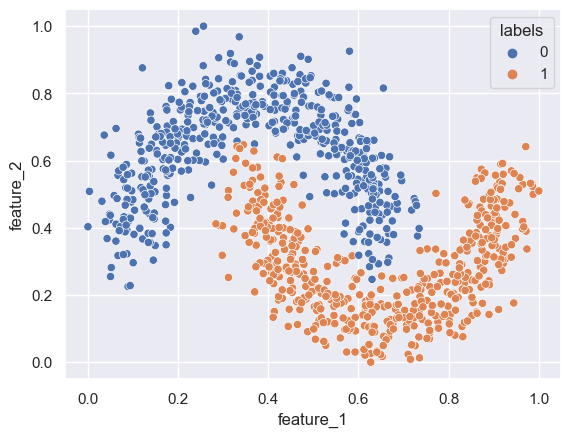

In [3]:
sns.set_theme()
sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)

In [4]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [123]:
df2 = pd.DataFrame(gmm.mu.detach(), columns=['feature_1', 'feature_2'])
df2['labels'] = ['gmm_center']*n_centers

In [124]:
# make grid for contour
x = y = np.arange(-.03, 1.03, 0.01)
points = []
for xx in x:
    for yy in y:
        points.append([xx, yy])

<Axes: xlabel='feature_1', ylabel='feature_2'>

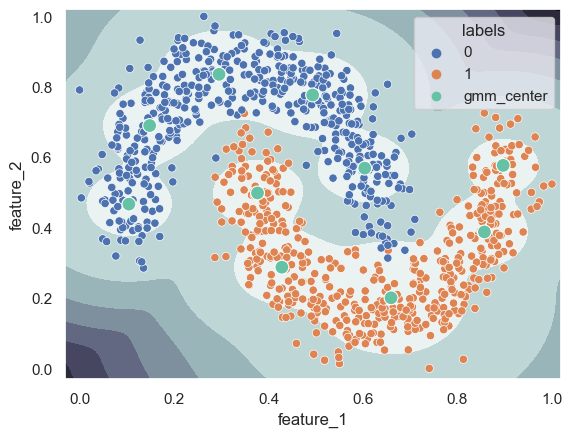

In [134]:
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
plt.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels')
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)
# sns.scatterplot(data = pd.concat([df, df2], axis=0), x = 'feature_1', y = 'feature_2', hue = 'labels')

### MLP Classifier

In [44]:
label = torch.tensor(labels, dtype=torch.int64)
train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

In [45]:
class TwoMoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]
loss = []
acc = []
optimizer = optim.Adam(param_groups)

for epoch in range(200):
    
    l,a,_= tt.train_plain(net.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1)
    loss.append(l)
    acc.append(a)
    if a > .98:
        break # converged

Text(0.5, 0, 'Epoch')

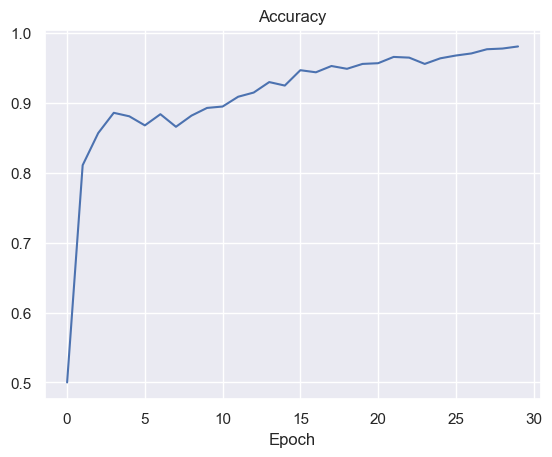

In [46]:
sns.lineplot(acc)
plt.title('Accuracy')
plt.xlabel('Epoch')

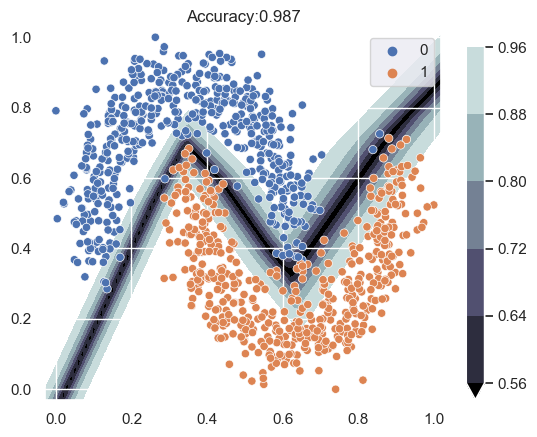

In [48]:
tt.plot_conf(net, data, label, device=device)

### CCU Robust Model Learning

In [49]:
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [9]:
gmm.mu.requires_grad_(False) # turn of learning of centers

Parameter containing:
tensor([[0.4699, 0.2452],
        [0.1741, 0.6298],
        [0.5905, 0.6179],
        [0.8688, 0.3153],
        [0.1031, 0.4175],
        [0.3968, 0.4249],
        [0.9114, 0.4938],
        [0.6368, 0.4799],
        [0.3898, 0.7465],
        [0.6769, 0.1577]])

In [50]:
data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000, dtype=torch.int64)


train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)

In [51]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

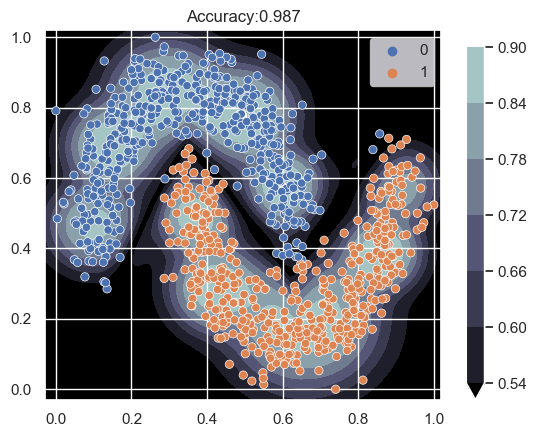

In [52]:
tt.plot_conf(CCU.to(device), data, label, device=device)

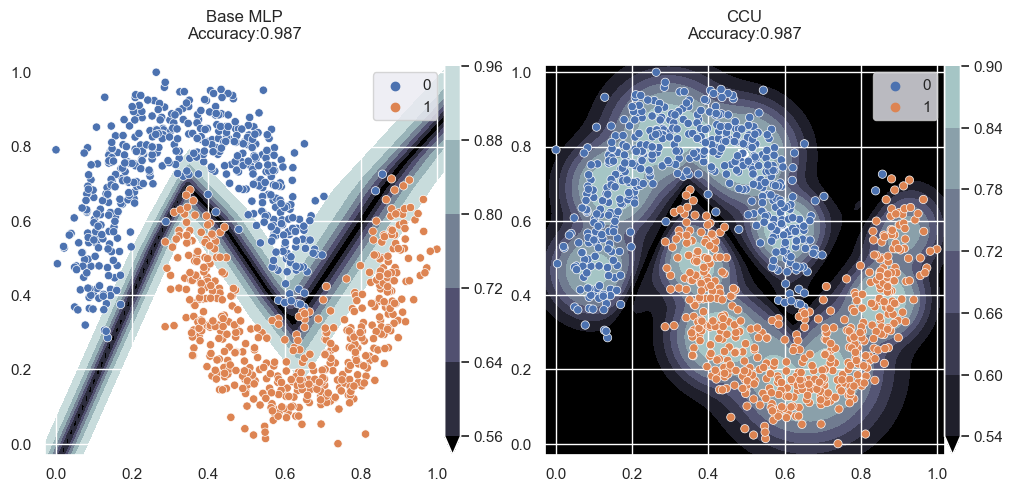

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.87,left=.05,wspace=.25,right=.95)
tt.plot_conf(CCU.base_model.to(device), data, label,
             ax1, device=device, title='Base MLP')
tt.plot_conf(CCU.to(device), data, label,
             ax2, device=device, title='CCU')
plt.savefig('Base_Vs._CCU_Confidence.png')

## RBFNet Classifier

In [232]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x, p=2, dim=-1):
    return torch.norm(x, p=p, dim=dim)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()


class TwoMoonsRBFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=10,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True)
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [246]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsRBFNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)

for epoch in range(100):
     tt.train_plain(net.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1,
                   )


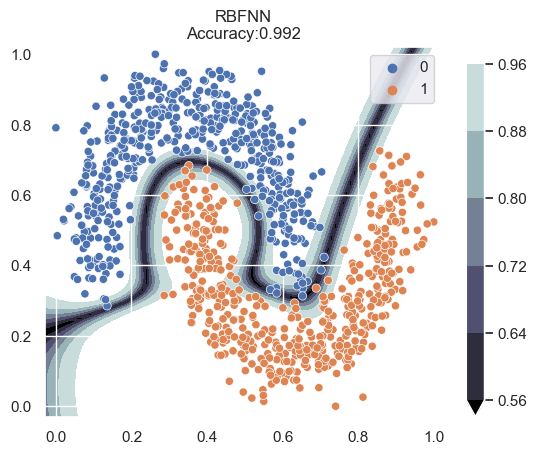

In [247]:
tt.plot_conf(net, data, label, device=device, title='RBFNN')
plt.savefig('RBFNN_conf.png')

In [248]:
kernels = net.rbf.get_kernels_centers.cpu().numpy()

<Axes: title={'center': 'Learnt kernels'}, xlabel='Feature 1', ylabel='Feature 2'>

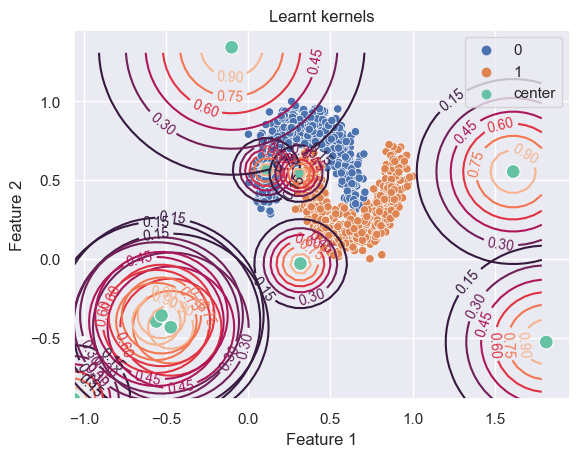

In [249]:
tt.kernel_map(net.rbf, df)
sns.scatterplot(x=kernels[:,0], y=kernels[:,1],palette='Set2', s = 100, hue=np.array(['center']).repeat(len(kernels)))

<Axes: title={'center': 'Learnt kernels'}, xlabel='Feature 1', ylabel='Feature 2'>

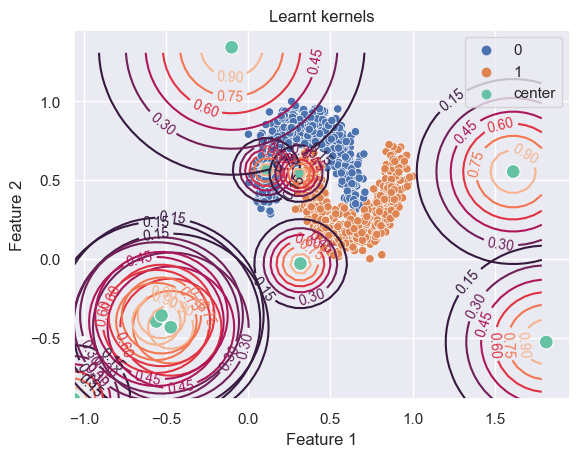

In [252]:
tt.kernel_map(net.rbf, df)
sns.scatterplot(x=kernels[:,0], y=kernels[:,1],palette='Set2', s = 100, hue=np.array(['center']).repeat(len(kernels)))

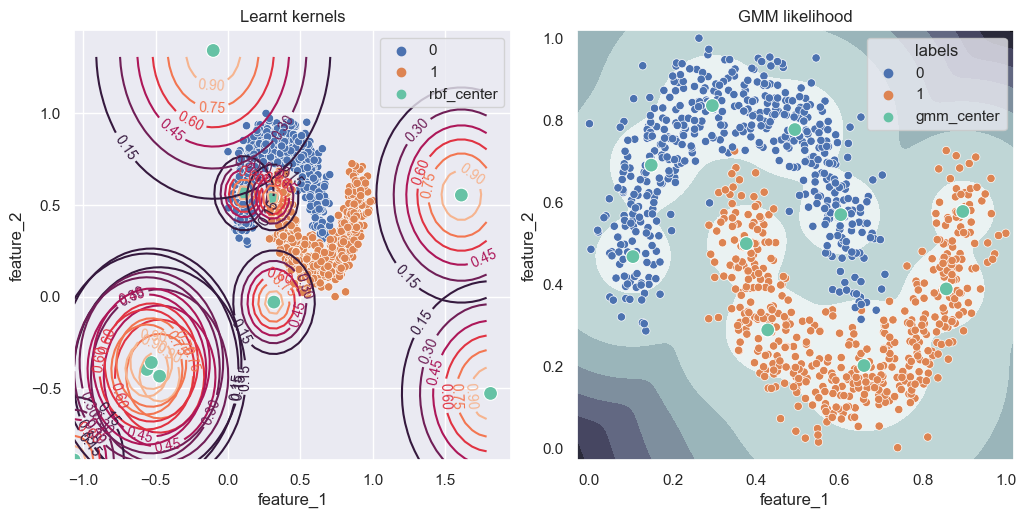

In [257]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.95,left=.01,wspace=.15,right=.99)
tt.kernel_map(net.rbf, df, ax = ax1)
sns.scatterplot(x=kernels[:,0], y=kernels[:,1],palette='Set2', s = 100, hue=np.array(['rbf_center']).repeat(len(kernels)), ax=ax1)
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
cont = ax2.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels', ax = ax2)
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100, ax = ax2)
ax2.title.set_text(f'GMM likelihood')
plt.savefig('RBF_Vs_GMM_Centers.png')

### Compare RBF output to GMM output

In [100]:
sample = torch.tensor([[.4,.4],[.7,.8]])
net.to('cpu')

TwoMoonsRBFNet(
  (rbf): RBFLayer()
  (fc1): Linear(in_features=6, out_features=2, bias=True)
)

In [101]:
net.rbf(sample) # rbf has 6 centers, gives distance from each center row wise

tensor([[ 0.9585, -0.1337, -0.0369, -0.0844,  1.6781, -0.0823],
        [-0.2409,  1.3967, -0.0067,  0.5423, -0.4557,  0.0064]],
       grad_fn=<SumBackward1>)

In [102]:
rc = net.rbf.get_kernels_centers
rvar = net.rbf.get_shapes
rw = net.rbf.get_weights

In [141]:
rc

tensor([[ 0.6475,  0.4787],
        [-0.2069,  0.5311],
        [-0.2965, -0.6113],
        [ 1.1562, -0.3234],
        [ 0.6367,  0.9992],
        [-0.3867, -0.5953]])

In [103]:
gmm(sample)# gmm has 10 centers, gives value in column for likelihood of each point from sample

tensor([[-18.9196, -42.1121],
        [-34.8513, -32.3593],
        [-11.2028,  -9.8521],
        [ -0.4313, -40.5461],
        [-14.3136,  -3.1136],
        [-10.4732, -57.1700],
        [-41.1629, -12.5378],
        [ -4.2837, -17.6005],
        [ -0.2788, -28.8456],
        [-15.2925, -12.3692]], grad_fn=<SubBackward0>)

In [111]:
gc = gmm.mu.detach()
gvar = gmm.logvar.detach()
gw = gmm.alpha.detach()

In [112]:
gvar.exp()

tensor([0.0036, 0.0029, 0.0027, 0.0040, 0.0048, 0.0040, 0.0033, 0.0095, 0.0032,
        0.0061])

In [118]:
gw.exp()

tensor([0.0846, 0.0754, 0.0827, 0.0873, 0.1212, 0.0676, 0.0478, 0.2269, 0.0745,
        0.1320])

In [116]:
rvar

tensor([8.4053, 3.9611, 2.1623, 1.5164, 4.8126, 2.1048])

In [120]:
rw.exp()

tensor([[0.7844, 0.7003, 0.9851, 3.1439, 0.6903, 0.9874],
        [3.3938, 4.6546, 1.0408, 0.7180, 4.7525, 1.0399],
        [0.9973, 0.9998, 1.0000, 0.9585, 0.9967, 1.0000],
        [1.5228, 1.8406, 1.0199, 0.8514, 1.8372, 1.0145],
        [0.6154, 0.5161, 0.9795, 7.4846, 0.5033, 0.9854],
        [1.0342, 0.9891, 1.0000, 0.9062, 1.0164, 0.9999]])

<Axes: xlabel='feature_1', ylabel='feature_2'>

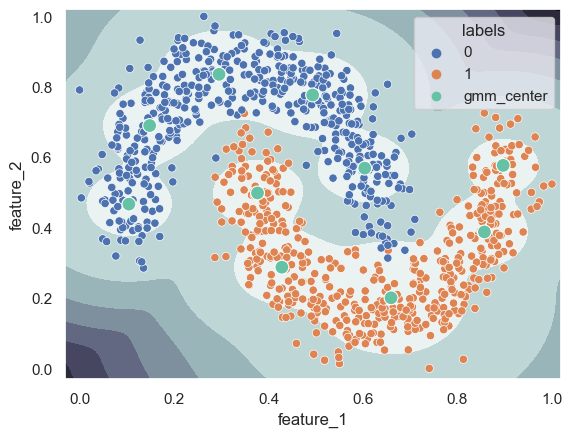

In [135]:
plt.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels')
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)

## RBF with CCU (with GMM and RBF seperate)

In [35]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

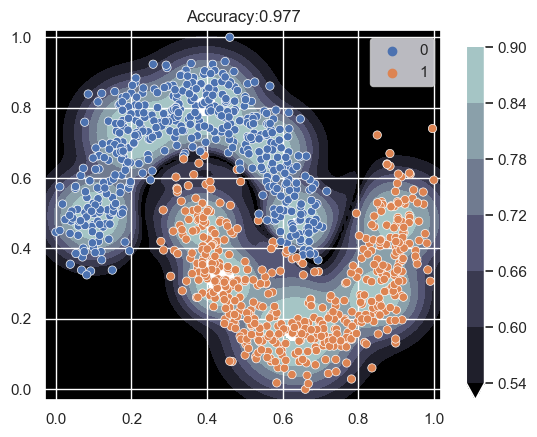

In [37]:
tt.plot_conf(CCU.to(device),data, label, device)

### Combine RBF and GMM centers